# Test modeling on larger synthetic dataset with 300bp
Use 5g sequences but score them simply.

Still try various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model


## ** Classification instead of regression
* overfit first?

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Load 5G data

In [3]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

data_filename = "data/XY_lr_noCu_opFilt.tsv"
XYdf = pd.read_csv(data_filename,sep='\t')
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237


In [5]:
# add synthetic score column
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}

m1 = "CACACA"
m2 = "GTGTGT"

def classify_seqs_motif(seqs):
    data = []
    for locus_tag,seq in seqs:
        seq = seq.strip("N")
        if (m1 in seq and m2 in seq):
            print("both motifs in seq - skipping")
            c = 'skip'
        elif m1 in seq:
            c = 2
        elif m2 in seq:
            c = 1
        else:
            c = 0
        data.append([locus_tag,c])
        
    df = pd.DataFrame(data, columns=['locus_tag','reg'])
    return df

In [6]:
syn_motif_dict = dict(classify_seqs_motif(XYdf[['locus_tag','upstream_region']].values).values)


both motifs in seq - skipping
both motifs in seq - skipping


In [7]:
XYdf['reg'] = XYdf['locus_tag'].apply(lambda x: syn_motif_dict[x])
XYdf = XYdf[XYdf['reg'] != 'skip']
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,reg
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143,0
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725,0
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782,0
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343,0
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619,0
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777,0
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596,0
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237,0


In [8]:
loc2seq = dict([(x,z) for (x,z) in XYdf[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


In [14]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()
    
def plot_train_test_stacks(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores in categories, sanity check that its not skewed'''
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    temp_df = pd.concat([train_df,test_df])
    if val_df is not None:
        val_df['set'] = 'val'
        temp_df = pd.concat([temp_df,val_df])
        
    temp_df = temp_df.value_counts([score_col,'set']).to_frame('count').reset_index()
        
    #temp_df = pd.melt(temp_df[['locus_tag',score_col,'set']],id_vars['locus_tag'])
    sns.barplot(x='reg', y = 'count', data = temp_df, hue = "set")
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,val_df,test_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"Distribution")
    plt.show()
    

def see_batch_class_dist(train_dl):
    '''Check distribution of classes in each batch'''
    
    data = []
    for i,(xb, yb) in enumerate(train_dl):
        vals, counts = yb.unique(return_counts=True)
        z=dict(list(zip(np.array(vals),np.array(counts))))
        row = []
        for cls in [0,1,2]:
            if cls in z:
                data.append((i,cls,z[cls]))
            else:
                data.append((i,cls,0))

    batch_dist = pd.DataFrame(data, columns=['batch','class','count'])
    sns.barplot(x='batch', y = 'count', data = batch_dist, hue = "class")
    plt.show()

def print_motifs_in_seqs(df, df_name, m1, m2):
    print(df_name)
    seqs = df['upstream_region'].values

    print(f"{m1}:",len([x for x in seqs if m1 in x]))
    print(f"{m2}:",len([x for x in seqs if m2 in x]))

    print(f"NO {m1}:",len([x for x in seqs if m1 not in x]))
    print(f"NO {m2}:",len([x for x in seqs if m2 not in x]))

    print(f"BOTH:",len([x for x in seqs if (m2 in x and m1 in x)]))
    print(f"NEITHER:",len([x for x in seqs if (m2 not in x and m1 not in x)]))

## Load 5G seqs into data loaders

In [10]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [11]:
full_train_df,test_df = tu.quick_split(XYdf)
train_df, val_df = tu.quick_split(full_train_df)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='reg',
    sampler=None
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

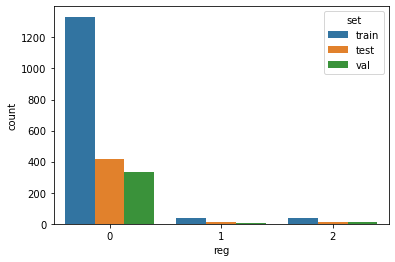

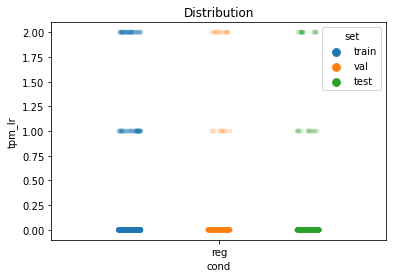

Train Seqs
CACACA: 36
GTGTGT: 39
NO CACACA: 1372
NO GTGTGT: 1369
BOTH: 0
NEITHER: 1333

Val Seqs
CACACA: 11
GTGTGT: 8
NO CACACA: 342
NO GTGTGT: 345
BOTH: 0
NEITHER: 334


In [17]:
plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col='reg')
view_train_test_dist(train_df, test_df,["reg"],val_df=val_df)

print_motifs_in_seqs(train_df, "Train Seqs", m1, m2)
print()
print_motifs_in_seqs(val_df, "Val Seqs", m1, m2)

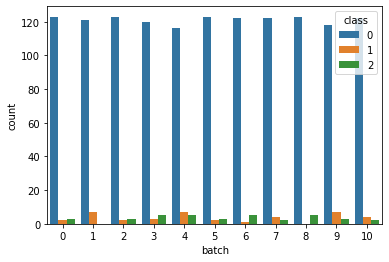

In [18]:
see_batch_class_dist(ohe_train_dl)

## Non-optuna regular ol training

In [19]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    #loss = loss_func(xb_out, yb.float())
    loss = loss_func(xb_out, yb.long().squeeze(1))
    # ^^ changes for CrossEntropyLoss...

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(DEVICE),yb.to(DEVICE)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(DEVICE),yb.to(DEVICE)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        train_loss = train_step(model, train_dl, loss_func, opt)
        train_losses.append(train_loss)
        
        
        val_loss = val_step(model, val_dl, loss_func)
        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

def run_model(train_dl,test_dl, model, loss_func, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses

In [20]:
class DNA_Linear_Deep(nn.Module):
    def __init__(
        self, 
        seq_len,
        h0_size=24,
        h1_size=24
    ):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h0_size, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 3), # 3 for 3 classes
            #nn.Softmax(dim=1)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 3),
            #nn.Softmax(dim=1)
            
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

class Kmer_Linear(nn.Module):
    def __init__(self,num_kmers,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin = nn.Sequential(
            nn.Linear(num_kmers, h1_size), ## TODO: Can this be combined? Bring num_kmers outside?
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True),
            nn.Linear(h2_size, 1),
        )
        
        
    def forward(self, xb):
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out

In [21]:
class TINKER_DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters0=32,
                 num_filters1=32,
                 kernel_size0=8,
                 kernel_size1=8,
                 conv_pool_size0=1,
                 conv_pool_size1=1,
                 fc_node_num0 = 100,
                 fc_node_num1 = 100
                ):
        super().__init__()
        
        self.seq_len = seq_len
        
        # calculation for number of linear nodes need to come after final conv layer
        linear_node_num = int(np.floor((seq_len - kernel_size0 + 1)/conv_pool_size0))
        linear_node_num = int(np.floor((linear_node_num - kernel_size1 + 1)/conv_pool_size1))
        linear_node_num = linear_node_num*num_filters1
        
        self.conv_net = nn.Sequential(
            # Conv layer 0
            nn.Conv2d(1, num_filters0, kernel_size=(4,kernel_size0)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.MaxPool2d((1,conv_pool_size0)), # def stride = kernel_size
            nn.Dropout(0.2),

            # Conv layer 1
            nn.Conv2d(num_filters0, num_filters1, kernel_size=(1,kernel_size1)),
            nn.ReLU(),
            
            nn.Flatten(),
            # Fully connected layer 0
            nn.Linear(linear_node_num, fc_node_num0),
            nn.ReLU(),
            # Fully connected layer 0
            nn.Linear(fc_node_num0, fc_node_num1),
            nn.ReLU(),
            # final prediction
            nn.Linear(fc_node_num1, 3),
            #nn.Softmax(dim=1)
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        return out

In [22]:
def plot_confusion(models,genes,oracle,objs):
    '''Get class predictions and plot confusion matrix'''
    dfs = {}
    for model_name,model,ds in models:
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            elif ds.name == 'kmer':
                s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).to(DEVICE)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")

            actual = oracle[gene]
            preds = [x.topk(1) for x in model(s.float())]
            
            for i in range(len(preds)):
                prob,cls = [x.item() for x in preds[i]]
                data.append((gene,actual[i], cls,prob,objs[i],dna))
                
        df = pd.DataFrame(data, columns=['locus_tag','truth','pred','prob','task','seq'])
        c = confusion_matrix(df['truth'].values, df['pred'].values)
        disp = ConfusionMatrixDisplay(confusion_matrix=c)
        disp.plot()
        plt.title(f"{model_name} confusion matrix")
        
        dfs[model_name] = (c,df)
        
    return dfs

### Deep linear

In [28]:
seq_len = len(train_df['upstream_region'].values[0])

mer8motif_model_lin_d = DNA_Linear_Deep(
    seq_len,
    h0_size=100,
    h1_size=100,
)
mer8motif_model_lin_d.to(DEVICE)


#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_lin_d,
    loss_func,
    lr=0.01,
    epochs=100
)

0 0.9686080168394462
1 0.7844085443458881
2 0.5743502925543205
3 0.3976039404403049
4 0.3050466579181952
5 0.26939714748528454
6 0.25622668351566485
7 0.2512395021007014
8 0.24925743461330618
9 0.2484856179516984
10 0.24823918406753973
11 0.24820022998382957
12 0.24824970901518975
13 0.24831928941751
14 0.24841019401469244
15 0.24849741376155496
16 0.2485894326532191
17 0.24868044050320687
18 0.24877643175739741
19 0.2488762962159624
20 0.248964642921183
21 0.24905785800039598
22 0.24914734686062626
23 0.2492577768334586
24 0.24933365434830318
25 0.24945326567371573
26 0.24952842577996404
27 0.24959642699690107
28 0.24969960153947132
29 0.24978503648181138
30 0.24991416272630773
31 0.24999730031483572
32 0.25008246011335517
33 0.2501536431714428
34 0.25024822101039185
35 0.25033784782244867
36 0.25040703995031943
37 0.25051106622300134
38 0.2506062672935194
39 0.2506779559357646
40 0.2507769274221939
41 0.25088439860695144
42 0.25098890256104994
43 0.2510607505570728
44 0.2511844348806

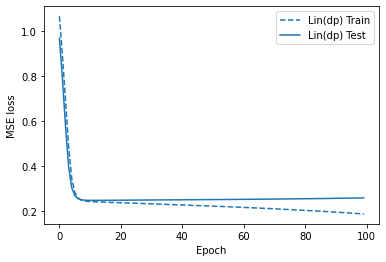

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [29]:
# to plot loss
mer8motif_lin_d_data_label = [((mer8motif_train_losses_lin_d,mer8motif_test_losses_lin_d),"Lin(dp)")]
tu.quick_loss_plot(mer8motif_lin_d_data_label)

mer8motif_model_lin_d

### CNN model

In [30]:
# make model
seq_len = len(train_df['upstream_region'].values[0])
mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=6,
    kernel_size1=6,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=3,
    fc_node_num1=3
)
mer8motif_model_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

# run model
mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    loss_func,
    lr=0.01,
    epochs=100,
)

0 1.3455559673795618
1 1.2662831247697133
2 1.1924805499338902
3 1.1239804144283867
4 1.0605432267904957
5 1.0019395233213733
6 0.947901001226463
7 0.898155492527289
8 0.852406826809513
9 0.8103650666498935
10 0.7717607990540458
11 0.7363110367029314
12 0.703765996117092
13 0.6738730969577605
14 0.6464072530060246
15 0.6211556474818049
16 0.5979177499290228
17 0.5765153024419509
18 0.5567922409803266
19 0.5385862561866177
20 0.5217682744558405
21 0.5062156162586158
22 0.49181277463186224
23 0.4784604721298974
24 0.4660689355462536
25 0.4545546862964252
26 0.4438336716157519
27 0.4338466021899799
28 0.4245352606597771
29 0.4158363157392561
30 0.4077036268481452
31 0.400088883746447
32 0.39295319600753675
33 0.3862601959333879
34 0.3799762128095113
35 0.37406744126219926
36 0.368507846809987
37 0.36327033323201513
38 0.35833462515566233
39 0.3536757694256542
40 0.34927374842146636
41 0.3451128772568095
42 0.3411746778163964
43 0.33744498876269075
44 0.3339108499690426
45 0.33055698694318

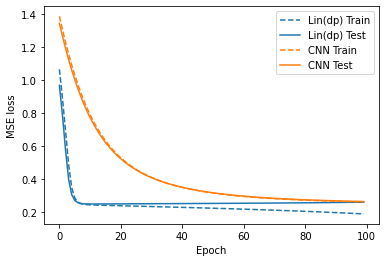

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 6), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2976, out_features=3, bias=True)
    (8): ReLU()
    (9): Linear(in_features=3, out_features=3, bias=True)
    (10): ReLU()
    (11): Linear(in_features=3, out_features=3, bias=True)
  )
)

In [31]:
# to plot loss
mer8motif_cnn_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN')]

tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label)

mer8motif_model_cnn

Running LinearDeep
Running CNN
Running LinearDeep
Running CNN


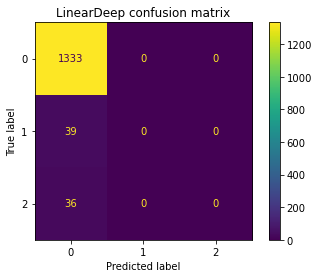

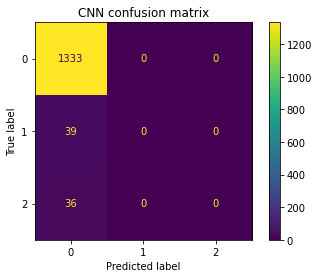

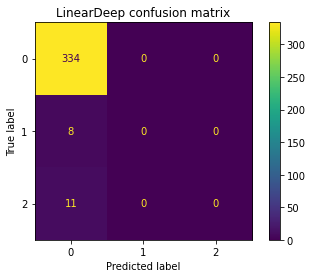

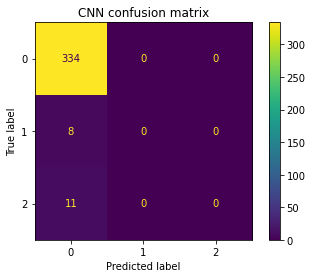

In [32]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


train_seqs =  train_df['locus_tag'].values #val_df['locus_tag'].values #
val_seqs =  val_df['locus_tag'].values #val_df['locus_tag'].values #
task = "6mer_motif_reg"

oracle_syn = dict([(a,[b]) for a,b in XYdf[['locus_tag','reg']].values])


dfs_train = plot_confusion(models, train_seqs, oracle_syn,[task])
dfs_val = plot_confusion(models, val_seqs, oracle_syn,[task])

In [46]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,precision_recall_curve

def cls_report(df,model_name):
    '''Basic print out of precicion/recall/f1 scores'''
    
    acc = accuracy_score(df['truth'].values,df['pred'].values)
    print(f"{model_name} (acc={acc:.3f})")
    for a in ['micro','macro','weighted']:
        p = precision_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        r = recall_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        f1 = f1_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        print(f"{a}: p={p:.3f}\t r={r:.3f}\t f1={f1:.3f}")

def quick_classify(model, seqs,oracle):
    '''Given some sequences, get the model's predictions '''
    
    for gene in seqs:
        dna = loc2seq[gene]
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        prob,cls = pred.topk(1)
        actual = oracle[gene][0]
        correct = (cls.item() == actual)
        if not correct:
            #print(f"{gene}: pred:{cls.item()} actual:{actual}")
            
            print(f"{gene}: pred:{cls.item()} actual:{actual} ({pred.tolist()[0]})")

    print('done')
    #return pred
        

In [64]:
cnn_res = dfs['CNN'][1]
lind_res = dfs['LinearDeep'][1]

cls_report(lind_res,"LinearDeep")
print()
cls_report(cnn_res,"CNN")

LinearDeep (acc=0.943)
micro: p=0.943	 r=0.943	 f1=0.943
macro: p=0.315	 r=0.332	 f1=0.324
weighted: p=0.895	 r=0.943	 f1=0.919

CNN (acc=0.932)
micro: p=0.932	 r=0.932	 f1=0.932
macro: p=0.315	 r=0.328	 f1=0.322
weighted: p=0.895	 r=0.932	 f1=0.913


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Rebalance sampler

In [33]:
from torch.utils.data.sampler import WeightedRandomSampler


In [34]:
# retry making dataloader with weighted sampler
class_sample_count = train_df['reg'].value_counts().values
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in train_df['reg'].values])
samples_weight = torch.from_numpy(samples_weight).double()


sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
sampler

In [35]:
print(samples_weight.unique())

tensor([0.0008, 0.0256, 0.0278], dtype=torch.float64)


In [36]:
# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='reg',
    sampler=sampler,
    shuffle=False
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

In [37]:
print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)

(1761, 17)
(441, 18)
(1408, 19)
(353, 19)


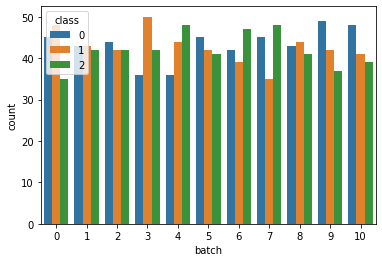

In [42]:
see_batch_class_dist(ohe_train_dl)
# the exact dist changes everytime

In [43]:
# make model
seq_len = len(train_df['upstream_region'].values[0])
mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=3,
    num_filters1=3,
    kernel_size0=6,
    kernel_size1=6,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
mer8motif_model_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

# run model
mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    loss_func,
    lr=0.01,
    epochs=500,
)

0 1.2379393212856045
1 1.2285758358223242
2 1.2148800544630705
3 1.2087449618844743
4 1.2001219690690297
5 1.194572628050958
6 1.1862099109898208
7 1.1741604224142879
8 1.1686981308561546
9 1.162313221196615
10 1.156669128380146
11 1.1572663223439505
12 1.1530000960860645
13 1.1494160806153382
14 1.1455422251487926
15 1.1401522713409942
16 1.1354394931631115
17 1.1314044886878125
18 1.1255257734158222
19 1.1229182637109296
20 1.120118280645808
21 1.1157057734454319
22 1.1124703624093162
23 1.1138245262437771
24 1.1095508965149141
25 1.1102224389149178
26 1.1079142677885276
27 1.1089623713966132
28 1.109194352674079
29 1.109567305183951
30 1.1080352858173272
31 1.106149552901811
32 1.1041910945524913
33 1.1035687234516522
34 1.104340605965417
35 1.1046943421404356
36 1.1012169831873
37 1.1003087867083023
38 1.1013526886110603
39 1.1008091263325288
40 1.097388355319966
41 1.0973565369084604
42 1.0972029075406429
43 1.1000946533916354
44 1.0996481186945108
45 1.0991333658904596
46 1.09810

372 1.0906067249119789
373 1.086846680208914
374 1.088314790225907
375 1.086557674002715
376 1.0866035425629224
377 1.0896486033798953
378 1.0884291963604287
379 1.0934943936701875
380 1.0920329830126452
381 1.0919253826141357
382 1.0903535439677685
383 1.089841453617085
384 1.0875580057544005
385 1.0848251999944196
386 1.088316546958837
387 1.089065146851472
388 1.0889317476040243
389 1.0888072356961604
390 1.08784365282518
391 1.093097187304294
392 1.0932643204167611
393 1.093135843533632
394 1.0919941282137258
395 1.0943762222700686
396 1.0931640606764017
397 1.0885991310600518
398 1.0885301993859051
399 1.0907828243866182
400 1.0868906647220211
401 1.0869889225568041
402 1.088285461701347
403 1.086053380209731
404 1.0847984150516412
405 1.083701588276763
406 1.0840032495790433
407 1.0838543139503631
408 1.0875103220385802
409 1.0915610253304326
410 1.0918234654256371
411 1.0954377610690196
412 1.0955882153497538
413 1.0933735758994862
414 1.0934484180580117
415 1.0954216188479415
4

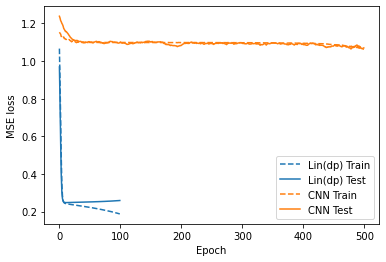

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 3, kernel_size=(4, 6), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(3, 3, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=279, out_features=10, bias=True)
    (8): ReLU()
    (9): Linear(in_features=10, out_features=10, bias=True)
    (10): ReLU()
    (11): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [44]:
mer8motif_cnn_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN')]

tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label)

mer8motif_model_cnn

Running CNN
Running CNN


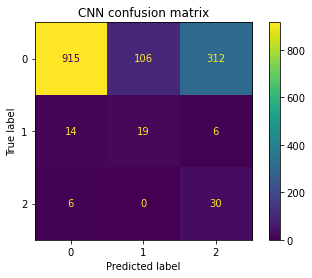

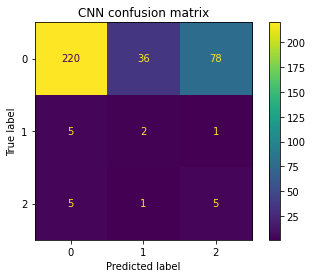

In [45]:
models = [
    #("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


train_seqs =  train_df['locus_tag'].values #val_df['locus_tag'].values #
val_seqs =  val_df['locus_tag'].values #val_df['locus_tag'].values #
task = "6mer_motif_reg"

oracle_syn = dict([(a,[b]) for a,b in XYdf[['locus_tag','reg']].values])


dfs_train = plot_confusion(models, train_seqs, oracle_syn,[task])
dfs_val = plot_confusion(models, val_seqs, oracle_syn,[task])

# filter viz

In [115]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0).to(DEVICE)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

import logomaker
def view_filters_and_logos(model_weights,filter_activations, num_cols=8):
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 40))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(model_weights.shape[2]))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

Total convolutional layers: 2


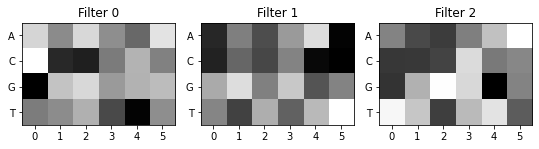

In [116]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(mer8motif_model_cnn)
view_filters(model_weights)

In [119]:
seqs = [loc2seq[x] for x in train_df['locus_tag'].values[:500]]

filter_activations = get_filter_activations(seqs, conv_layers[0])

Num filters 3
filt_width 6
Running seq GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGCTTCTTTACGTGATTCGGATGTAAAGCTTGAGGAAGATTATTTAAACCTGTTGAGAACATTGTCGCATTAACGGTGTTTAACTTGTGGATAACTATAGTCTTTAGCAGAGAAGGAGAGTTATCCTCTTTTTATCAAGCGCTTATCCACAGCTTTAAACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAAATGACTTATCACGCTTTTTTTATAGGCTAATAGTAAATATAAATAAATATCTTA
Running seq TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGGATAGCCGCCGTCAAGCCTACACGGACGTATTCACGGTGTCCTGTCGGTCGAGTGACCGCACCCTCAGCTACCCAGAGCTTTCATTTTCCGGGGCGATGACCTGGCTTTCATGAACGTTAAGGTCAACTTTTCACTAACTTCCTGAAATTTCTAAATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGTTGTTCATCTAACCGGTGTTAACCGCGTGCTTTTTTTGACTAGCAACTAATAAAC
Running seq GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCGATAGCGGTGTGATTTGATTTCTCCCGGCGCCTCCATACGCTAATACAGAAATTTGAAGTGCGAGGGTATCGCATAAGTCGGGCTTAAACCCATATAGGGACATTTAATAACTATTTATTGCCGACAACTATTGTCTTATCTTTCCGGTATTCTTCGCTTAGAATGGCGTATTAATAAACCTTAATAACCGTAATAAAATAAATTGCCGATCATGTTGTTTCTAAGATTCGGTAAATCAATAAACGGATAGCCAT
Running seq ACTTTTACGGGACCCAGACTGA

Running seq TCGATGCGGTTGCGATGGGCGGGGCGGCGCCGGTCATGAGAGGCTTAACAAATATATCTGCTTGGGTACCTATCGGGAGAAGTAGAGCCGCCGCTTATCAAACGATGGATGAATAGGTAGTTGGAGTTTCTATGAGTGAAAATTTTTCATCGTGAATGTTGCTGTACCTTTGATCAAGTTTCGGCACGAAAATTTGGTTGGCAATGGGTAAACAATAAGTTGCTTCATGTCACTTGAGTTATTTACGCGCGGTTCAGTCGCGTGATTTTTCGATTGTTTGGATTTTAAACCGAGGTTGAA
Running seq GGAGGCACCGGGATGCTAGGCCGATCTTTGCTCCTCGGCAATCGCTGAGATACAAGGATGTAATGAATGCAGAAATGCAGTAGCATTTTTCTGCCCTGCATCGCCTAAGCGCTAACTGTTGAAACCCTAATACACGCCATTCATACCGCTTGCAAAAGCTTTGCCTACATTGACGTATTACCGGCGTCCTTTGACGACCGCCCGGTGCCGAATTTTGATCTACGATTGGTCTATAATGAAAAATCTTCTTAGGATTTGGTCGTAAATGACTTCACTATATTACTCCCTTTATACTCAAAA
Running seq CTTGACCATATAACACCCAATCGGTTTGAAAACCAGAGTGTTATACAACGGCCGACAATCGCTAAAGCGAGAGAGCGAAAAACGTGTACAGATTTCCAAAAAAACAGGTGAAAAGAGCAAGGTAAAAGGCGCAAGGCGAAAGGCTAAGCGGCAGAGACCGAAAACCCTGATAAAACCGAAAACACCTGAAGTAAAGAGTTTTGAGTAGGCTCAAAGCAAGAAGCCGAGAGCGTATCGAGTGAGTTAAAGAATACCAACTTATTCCTTACGGCTTAGCGTTGAACCTGCTGTAACCAGTTT
Running seq ATTCCGATGGGTATGTAACCAAATCTTTAGTAGCTGAACGCGACTGATC

Running seq GAAAGCTGAAATGGGGCCCGTCCGATTTCAGCAGCGAAAAATGACTTGGCGATTATTGCCTTCGGCGGCCCCGATTCGCCCTGCGTCCGTGCCACTACGCCACATCATCGTATACTCGATGCGGCTCCGTAGCACTCCCACAAATGGCTTTACGCCGTGTCGCGATGCCTTGTATTTTGCCTCCGCCTGCGCTATTCGCGCAGAATCCGGCAAAACACCCGGCGCTACGGCTATCGGGGACTAAAAATCTTCACTTCGCTAACGCTCCGTTTCCAAGATTTTCAGCGAAGGTAGGTAAAC
Running seq CACCGGCTTGGCTTCGGCGACTTGCTTCAAGGCCGCCTCCCGTTCTTCCTTGACCGACGACAACGGAATGTTGATCTGCAGGCCGCCGAACACGGTGTAAGGATCGTCCCGGAACTCGGTGCCGCCGACACTGACCCGGCCGATGAACGACAACACGGCGTCGTCATCCCAGGCCGCTACCCGGAAAGGCAAGAATAAGGCTACAATAAAGACGATTCGCACGATCATGGATTCACTTTTATCATACAAAAGTGTAATTTTGTTTTAACTTAGTCTAGCTTTTGTAGCCGCAAAAGTGAA
Running seq ATTGCTTCAACAGCACCGGTAATACGTTGTTTATCAAGGGTCGAATTAAAGGCAGGAGCGGCAAGAGCTGCTAAAATCGCGATAATCGCAACCACAACTAACGCTTCAAGAAGAGTGAAACCTCCGGAACACGCACTATTCCATAAGGAAGACATAGAGAGGGGGTTTTTATTCATTCCATTATTATGTGGCTGCACAAAAAATAGCGCCTAATAAAACGCTATTCGCATTATGCAATATGCGGTATTAAGCTACAAGCAATGATGCGAACCGCATAATGTGTTTGAAACAAAGAGGACT
Running seq GGATATTCGCCTTCCAAGTCGTAATCGGCCATCGCCGCCCCGAAGCCTT

Running seq GGAGCCTTGGCCAATTCAAGCGGATTCATCAAAAGTTCTACCAGTCGCTAATAACGAACGGGGCACCCGATGCCCAAATTAGGTAGCAAAAACTTACCTGATTAACAAGATGCTTCCGCTTGCGGAAGCCAAGTGTCCGCGCAGGGGCCGGTCGTAGTCGCAAAAACTTCATTATGCTGTTACCCAAGCTCCAGCTCTCGTCTTTATACATAAGTATAAATATATCTAATTGTGCAAAAAGTAGCGACCGAGCGCTAAATTACAGCAATTCCCAATTTGGAGATCAAAAAGGGTGTGGGG
Running seq TTTTAGGGTGTGGGGTATGCCTGTCGAGGAACGCCGTAAACCCATCCATGGGGCTTGGCGGCAGCTCCCTGCTGCCGACATCCTCGCCAAGCATACCCCACACCCTTTTTGATCTCCAAATTGGGAATTGCTGCGGTGTTGCGATTCCGAAATCTTATATTGGCTCGATAATATGACAAATCGATGACTGTTCTCGATTTAACTGGGATCGGCCGGCGATGACTAAATGGTTATCGCTTCATCATCCTGTCACAATATCTTTTTACGATCGCGTATCGGGGTTAATTTCAGCGGGGCGGT
Running seq ATGCATCAAGCCGGCAACTTTACCGTCCAAGATGTCGAAAATCACCGCGATGAATAATAAAGTCGCACCGAGCACTAAATTTCCTTCGATCGACATGATGATCGAAAGAATGCCGCAGGACAGATTCGCTACCGTGAAAATGTCCGCTAGTTTCAGATATTTGATTAGATACATGACCGCCCCGCTGAAATTAACCCCGATACGCGATCGTAAAAAGATATTGTGACAGGATGATGAAGCGATAACCATTTAGTCATCGCCGGCCGATCCCAGTTAAATCGAGAACAGTCATCGATTTGT
Running seq CCCATACATTTTTCGAAAACCTTCGGCATGCTTCATGGCTTGTATCTAT

Running seq CGGGCTACCCAAGCGACCTCGTAGCTCGGATGGAGTGCAACGCAATCCGGGGCAATCGAAGCCACGAACTCCCCGTATTCCGCTGACGCTGCATACGGGCTACCCAAGCGACTTCGTAGCCCGGATGGAGCAACGCGCAATCCGGGACAATCGGGGCCACGAACTCCCCGTATTTCCCTACGCTTCATACGGGCTACGAAACCCTTCCCAATAAAAAAATAAAAAAAACAGTGCGGTACTTTATCACTTCTCCGTCTTATCAAAGACACCGTTCATTTTTCGATAAGCTTCAGGAGAAAC
Running seq CCGTTGGCTGCAAAAACGCCGGGCGAAGCGGACAAAACACGGAGGTTCAATAGCACCGTAGCCCGGATGGAACGTAGTGCAATCCGGGAAATTCGAGGCCGCGCCTTTCCCGTATTCCGCTGCGCTGCATACGGGCTACGAAGCTACGAAACGCCTTTCCGGCTACGGGGTCAAGTCTTGACCCCGTTGGCTTAGTCTGATCAATGGCAGTATGGATCCGGGCGCAGTTAGTGGCGTGAAGTGCGTTTAAAACAAATACCGCTTATAATCTGACCAGACTGGTTAGAATTAGAGGTTGAT
Running seq TAAACAAAGCTTTGGTTTCCTCGCTGTTAGCCACGACTTGATTATTCCAGGTTCTATGAGCTAGTTTTCTAGGCAGATACTCCTTGATCGCGAATTGAACCTGATCCAATCGCCGGCGGGCCAAGTAAACGGAACTAAAGCCGCCGCGCGCCAATTCCCGCTCGATCATATAGTCGTCTATAATGGTGCCGGATTGGAGATAATTCCATTGCTTAGGATAGTTATCCGGATCGTAGTATTCAGCCACTGAGTCGCGTCATTGGGTTAATTCGTGTAAAAACACGGCAATTATAGGTGAAA
Running seq TACAAACGAAATGCTTTGTTTCTGACGTTCCGATATTTCTGAGTTAAAC

Running seq AGATTTTGCATGGAGCAAAAATCTGCCCTGCTGCCGACATCCTCGCCAAGCATACCCCACACCCTTTTTGATCTCCAAATTGGGAATTGCTGGATGTATTCGACGAGTCGAATTGGTGCTTCATTGCGCCATAGTGGTGCATTGTTTAAGAATAGAAAGAGGAAGGATTTTATTTTTACTATAAAATATTACTTTGGCATGATTTGTGTCTAAATTTAGATCTGGAGATATAGATGACGGATAAATTAAGCGATTTATGAACACGATAATTGAAGCGAATAAAACTAAGTTACTGGCTGC
Running seq TTATACCCTTTGCTAGTCAAATTTCGGCATCGGGGTGCCCGTCAAAGGACGCCGTGAATACGTCCATGTAGGCTCTTCTATGACAGCATCCATGCTGCCAAAGCCTTTGCCGAACACCCCGACGCCTCCATACGCTAATGCCGAAGTTTGAAGTGCGATAGGTATACAACGATTTGCGGACGGATAGAACTTAAGTGATAAAATATCGTCAATTATGAATCATGACTCGACGGCGCCGTTTTTCAAATTCGCTCCGTACCGAATCCTTTCCAATCGCTGATTATACGACTCCAACCTAAT
Running seq CAATATTGAAAACGGTAAAGTCAGTTTTTTTGAATAGCCTACTTCTACATTGTCGCAGCCGAACAACAAATCAAAAGCAACGACCCTAGCTTATTAAATCAACCGCAACAAATCCGCCGAGTTTTTGTTTTTTGTTGAATATCGCTATAATGCATGGTCTTGCTCGTTATATATCAACAAGCGCTGGTTTGCAGAATAATTCTTTAGTGTTATAGTTGGTTATTATCGCTTGACATGCGTTGTCTTGAAAAAGCAACATCCCCAATAACCTTTTCCGGCATATCCGGATTTAGTTCAGCC
Running seq TTTATATATTAAAAATCAATAACTTGCCAAGATGTAAATATACAAAAAA

Running seq GGGTGTCCGATAAAGGCTTTGCCTACATATACGTATTCACGGCGTCCTTTAGCGGACACCCAGGCGCCGAATTTTGATCTACGACGGGTATACTTGATTTCAAGGATTTAAATACAAAGCCTTAAACAAGATAAGATGCATAAACACTGCTCATACAAAGAAAGCGGTTGAAAAACTCGAAAAGCGAGTTCATCAACCGTTATAACTGCTTCAAATTCGGCTAACTATAATGGTATATTGCCATGTCAAAAACTATAAAAATCAAGTCTACGAGGCTCAGCCTTTACCAGGAGTGCAATA
Running seq ATTGTCACATAGACCCCGTAGATCAAAATTCGGCGCCGAGGACCGTCAAAGGACGCCGTGAATACCTCCATGTAGGCTCTATGACAGCATCCATGCCGACCCCCTCACCTAGCGTTAGGTGAGGGATCGAGCACCCCGGCGCCTTCTTAGGTAATGCCGAAATTTGAAGCATGGAAGGTATAGATCCCCCGGATTCATATAATAATCCGGAGCAATCCGTTAGATCGACATTGCCCTGATTCTTTTATCGATTAACCGCGACAAGCCCCAGCCATCACCCTGAATACCGTTGACCCAACT
Running seq TATATTCTTAACGAAGGTAAAGTTATTGCTGAAGGCGATGCTGAGGCTATAGTCCGTAATCAAGAAGTAAGAAAAGTTTATTTGGGTGAGAACTTCAGCCTTTAGCGTTATACTTCAAGCAAGTGCAAGACCGATTGCTGCTATATTTTTTGGAGTCGTTAACGACGGTGTTTATATTGGTCTGCGGGAATTAGAGCCGGGAGCCAGAAACGCGCCCTATATTGTTCGAGAATCATATTCCTGACCAAAACATCCAAAATGATCGCTTGATGCATGGATTAATAATGTTCAAACTTATAC
Running seq CCCTTAACACAACCACTGACCGGCGTTAGAGTAGACCTTGACGTCAAGT

Running seq GAGAACAGCTTGCGGTACATTGATCGCGAACGATGGGTATTCTTTCTCCTGATTAGCAAGTTTCTTCAGCTAAAGCCTAAAAACCAGTATATCCCAAGCAGGACGGGGTTTGCAACCCCGTCCTAAACGTTTTGACTTTGGCCGAAGTCAGCCGAAATGTTTAGGGCAAACCGAAACGTTGGGGACGGGTTAAATAACCCGTCCCGCAGAAGTGGCTACGACTGGCCACTGCTCGGACAATTGGCTTCAGTAAGCTGAAGCATCTTGCTAATCAGGTTCTTTCTTAAGATGGTTGGATAC
Running seq ATCAACCTAAATTCGCAGCTCAACCATGAAGCACATAAAGTTAATGGTGAAATGCTTTTTCTACTCCCTTTTGATTGAAAAACCGCCTAAGAATAAAAGATATGGGATGTGTCTATCGAGGACTGCCGAGACCCCATCCATGGAGGCTTGGAGTGCGCTTGGCGAGAATATCGGCAGCCGGGCAGTTGCCGCAAAGCCTACTACCTGTAGAAGTTATTTTGTTCATACTCCTAAACTATCGGTTTATTCGTGAACTCGTTTTATAATTCCCGCTTCGCACACTATAAAGAAGATATTCCT
Running seq GCTAAGCATTATTGCCTCTTCATTGACTTGTATCAACTATACCCATCGCACTTCAAATTTCGGCATTGACGTATGGAGGCGCCGGGGTGTTCGGCAAAGGTTTTGACAGCAGGTATGCTGTCACAGGGCCTACATGGACGTTTCACGGCGTCCTTTGACGGACACCCCGGCGCCGAAATTTGACCAGCAAAGAGTTATATAGTCCATGAAAATAGTAATCCACACAGGATTCATTAAGGATTTTATATTAAATATGTTTAGTGTTATTAATAATAAATGCGTGGAGCTTATATAAACCAT
Running seq ATTCTGGGTCCATGCAGCGCAGACATTCAGCCTTGGCATAGCGAAGAAG

Running seq CCCGCTCGCATCACCCCGACATTCGCGCCTATTTGGAACCGAGCCATTTTGCAGATTTTAGAGTGGAATACGGTGAATTAATTTGGGGAGATTATGATCTGTGTTTTCCAGTTATCGACCTTTATCGGAATACGATCGAGCATTATCCTCCAACCACAACGGCTGCGGCATGATGCTTTACACTATGCGACCTCCATTTTCGATCTTTGACCTAATCCGAGGTCAAGATAAACAAAACATGCAAGTAAGCAAAAGTCGTTTCCGAAGCACCAACCTTTTTATTTCTTAAAGCTGCGTTGT
Running seq TCAATGCTATCGATTGACGGCGGATTGGGTTGTGGTGGTAGAAACATGAGGGTTTAGTGAGGCGTTGTTGCATAAATATAGCATTTCTAAAACAATTAGTTGCAGGATTTTCCTGGCGTTGCTTCTCTGGTTTTTAGCTAGAATGATCAGCGGCATTCAAAGATTCACCTATAAATACCTCTAAACCAATGGTTTAAATTCAATATTTATGCGCCAACGCCATTTGGTGAATCAAAATACGAGGCTATTCGAAGGTGATTGGTTTAAGCTTGTTCCAAACTAGAAAAGTAAATGGAATTG
Running seq AATCAGCCAATCTAGCGGGCGTCAGTGCATTTGCTCTGGGAAATACACGTCGCCACTCGGCAATTCTGCCTTTATGACTTGCGCCAACGTTACCCGCTACGCATGCGGACGCTTTCTCTGATCAAGCGCGCAAGAGTGTTCGCGAATGCCGAAATGGGTGCGTTCGATTTCAGCAGCGAAACGTTACAGAGCGATTGTGGTCCTGCGTGCCGCTACTCCGTGTCATCGCCCGAGTTGGATCGTTTCGGACGGTGTGGCAGCGCAGTGAGTGTAGTAGACTTCAGTTAAAGGAAAAAGCGG
Running seq AGGTGGGCTTTCCCGATCTGGAGCTTGGGGAATAGCGTGATGCGGGTTG

Running seq CCCGGTCGTCTATATTCGAGGTCCTGATTAGCAAGTTTCTTCAGCTAAAGGCCAAAAACCAGCATATCCCTAGCAGGACGGGGTTTGCAACCCCGTCCTAAACGTTTTGACTTTGGCCGAAGTTAGCCGAAATGTTTAGGGCAAACCGAAACGTTGGGGACGGGTTAAATAACCCGTCCCGCAGAAGTGGCTACGACTGGCCACTGCTCGGACAATTGGCTTCAGCAAGCTGAAGCATCTTGCTAATCAGGTTCGAGGTTATAAGATTTCCGGGTCCATTTGTATTTAGTGCGAGAAAAT
Running seq ATTCGCCGGTCAGCAGTATCCAGGAGATATGCGTTTCCAATAATTCAATCGTAGCGCTTGCATGAGGGTATGCTCGGCTGTTGAGGAGTGAAGGGATCAATCGAGTTTCGAGAGGGGGTGAATTCATGGGTTAAGCCCGAAGCAGTTTTTTCTGTATGATACCGTTAATTTCAAGTAGGGCAATCCTTTGTCCTTGCCATACGGTTAAGGGTTTGTTCGAGGTTAATGTTTATCGGCTTAGGTTGACATTGTTTGTTGCAACAAGCATTATCAGGCGAATTTATTTTAATTTAGACTCTT
Running seq TTTGCGATGTTGAGAAAGCGCTTTTTTGTTCGGTTAAGGCAGTTCCTAGAAATGCTCCATGAGCTTCATGGTTGTACCCATCGTGGATCAAAATTCGGCACCGGGGTGATCGTCAAAGGACGTCGTGAATACGTCCATGTAGGCTCTATGCCAGCATTCATGCTGGCAAAGCCTTTACCGCTCACCCCGGCGCCTCCTTAAGCATCGCCGAAATTTGAAGTGCGAAAGGTATAAATTACCGAATTCAGGATAATCGGTTCACCTTGTCGAGAAAACCCAGTCGGTTTTTAAAAGCCATCC
Running seq AGTAGTTGAAAATCCGCATCATTTCTCTATTCTCTATTCTCTATTCTCT

Running seq TGAAACAAATCGCAGGCCGTAACGTGATTATCGAGATCAACGATAATCCGAGTATCGATAGCGGTGTCGAGGACGATTATTTGGGCGAGGATTTGTATCGCATCATCATGGAGGAGTTCGTGCGCCGATTGGAGCGCAAACATAGTGCTTATGCTTGAGACAGGAAATTTCAAGGCGGTTTAGGAAAAAGCATAAAATAACTTCCCTAATGATTTCTTCGTTCCGATTGAGAGCCCGGATGCCCTAACCGCAGCGTACCTTCGAGTTCCCTATTATTTTCAGCAAACCGGATGAGTACAT
Running seq GGCGGCTGATTATGGACACGAGCAGCACGGTGTAAGCCTTGCGGCGTATGGCAAATGCCGGAAAAAGGGAGGTGGTTGAATTATAAAATAAACCCGATACCCTTTTTTTGCAGTTTTGTTTCGACCTGTCTAGATAGAGCTAAGGAATATGCACAATATAACGTCTACAAGCAATAGGCTTTGCGGCGGTTCGGTGGCACGCTTGACAGGACGCCGAAAATACAACCACGTTGACGGCCTTGGTATGTGCTGCTAGATACCTGTACAATTTAACGTACATGATAATTTTAGAGAGGCCCC
Running seq ACCATCTGCACAGACTTCGGATCCGCTTGCAGACTCATCCCTGAAGTCTTGGACGCCCCAGGTTTTGATGTCGAGTCTCTGAATAACGACGCGTCAACATAGGTTCGGTTTAACTCGTCTCTCTGTACCCTACCTGCTAATTATGAATTAGCTTTTCCTCAACGCTCACTACCTGCACTCTTAATACAAGCAGCTTGAGGTGGTTTAAAGCCGGTTTCCGACAACAGACTTTGATGGACCTACCATCATCTTCCAATGAGCTTATACACATCTGATCGCTATTTCCGTATAGCGTCAGTT
Running seq ATAAAGATGTGTAGATACTTATATTGAAAAAGAGGGGTTGGGGCAGATT

Running seq GCCTACTTAAACGGCGCTTCGCTACAAAACATTTATTCCGATGCATTTCATGTCGCATCGCCTACACTGGACTGATACATCCCCTGATTTTCGTAGGGTACGCATCGCGTACCTATTTCGAGGTTTGTTTTTTCTATTACGTTTGTCAATGGTTCGATGCCTCACGTTGAGCCTTAGTACCCGTTCCTAAGCAAAAATAACCGAACCTCTTTCGGTTATTTTTTGGGGTTCCGTCAATCGGCGAGACCATCATTTTCATTCATGCCAGCCGGATTTCGCTGCGCAAATTCTTGAGTCGCT
Running seq AAGGATGTTTACTCCGTTTTGATTGAAAAACTGTGCTAGCCGCACCCCATACCTTCATAAGGATTACGTGATAAATAACGTCCTGGAACTGTAAGCTTTGTTGAGGGTTCGGTAACTCGCTTGACAGGATGCCGTGTACGTCCGTGTAGGCTCTATGCCAGCTCCATGCTGGCATAGCTTTTGCCAGTGCCATGGATGGCGTGAATGTCGATTTTGCAGGAGCAAAAATCGACCTAACACCCCGGCGCCTCCTCTGGCATTGCCGAAATTTGAAGTGCGAAAGGTATATAAAGGGAGGAG
Running seq TGGCCAAGCTGCATTTGCTGCTTTTCGATCGTTTGTTTTTGGAACGAGGCCGACTGGCGCGATTGCTAAGTTTGAAATAAACAAACCGTGTGCAATACAGGCCGGCAATGCGAAATTAAGGACCGAAGATATACCCATCGCAGATCAAAGTTCGGCACCAGGGTGTCCGTCAAAGGACGCCGTGAATACATCCCTCTAGGCTCTATGCCAGCTCCATGCTGGCAATGCCTTTGCCGCACACCCTGGCGCCTCCTCAGGCACTGCCGAAATTTGAAGTGCGAAAGGTATAAAGTGAGGTCT
Running seq CGATGGAATGCCATTCTTTAACGGTACAAACTGCCTTAACCAATCTAAT

Running seq TGCGATAAATATCGCCGCATTCAGCGGCAATCGCAAAATTAGAAAACCCTTTATCTATCAAAATCGTTTCTATCTGTGCGACAGTTTTCCGATCCATTCCGGCAATAATGATTTTACTTTGTCGCTGAGAGTTACTTAACATCGTATTCACTGGTTGATGTGTTAAATGCTTGACGGCTTCCTATTCGGACTATTTCTCGATGAAGCCCTTGATTTATTGCAAGCCTCACCTAAGCTTGACTGCAATACACTATAAAATGTCAAAACTCCAACAAGTATAATGAAGAAATCTGTTTTGCC
Running seq TTTCGCCGGCATCGATGATCGATTTATAAGGATCTTCAATCGTTTTTTTTAGCTCGAAATAAATCGCCGGCGGCGATGTTAATTGAAGATCGCCTTTCAATAAATCGGCTGCGGTTAAATTGGGCGAGTCGGAATGCGGCATTGGCAAAACAGATTTCTTCATTATACTTGTTGGAGTTTTGACATTTTATAGTGTATTGCAGTCAAGCTTAGGTGAGGCTTGCAATAAATCAAGGGCTTCATCGAGAAATAGTCCGAATAGGAAGCCGTCAAGCATTTAACACATCAACCAGTGAATAC
Running seq ACGAAGTACCTCTCATCGCACCGATCATCTTGTTGAAGCATCATTTTCGAAAATCGCCGGATCCCTATATTCAGTCGTCGTATTATTTTTCGCCTTATCCGAGCGCATTGGGTTCTGTTAATCCTTAAAAAATTCTCAGTGGTTATACTTCGCACGGTCACATTTGCTGGCAAGCTGGCGCGCTATTTTGTCCGGTAGCTGCGTTACCTACATGGACGTATTCACGGCGTCCTGCCAGCGACTGAAGCATAGACACACTCGCCCTTGAGGCTCAAACCATGATAACGACAAGGATAATAC
Running seq CGCGGTTTCGTTCATGACTATACCTATCAAACTTCAAATATCGGCATTA

Running seq TCCGTTTTCGGCAAATAGGATTTGATGCGCTTTTCGCGATAATAGCTTAAACAGCATCAGTCTGTTTTGCTCTATGTCGTCTACGACCAATATTTTCATGGCTTGATGTGATTCGTGTGAGTTGAACTATTGTGACGCAATTGTCAATAATAGTTGCGCGTTATAAAACCGGCAAGAAAATAAGGAATCTAAGGCTCGAAGCAGACCGGTAATTGCTATAAAATGAGCGGGTTTACCTTGATGTTGCGGTTTAATTCGAGCTTGCCATGAACTAGCTCAACTATGACGACTTTATGATTT
Running seq CACCGGGGACCCGTCAAAGAACGCCGTGAATACATCCATGTAGGCTCTATGCCAGCATCCATGCTGGCAAAGCCTTTGCCGAGCACCCCGGCGCCTCCTTAGGGACTGCCGAAATTTGAAGTGCGAAAGGTATATATGTATCGACAGAGTTAAGGCACAATACTTTCAATTAAACTTTCGAGCAATTATAGACCAGGTAGAACTGTTTCAAAAAATACTACTCTATTTATAATTGTCGAATCCGTGACAGGGTTATCCTAAACACCTTATTCATCCAACACCATCCGACCGTACGAAACC
Running seq GTTAAATAACCCGTCCCGCAGAAGTGGCTAAGACTGGTCACTGCTCGGACAGTTGGCTTCGGCAAGCTGAAGCATCTTGCTAATCAGGTATAACGATGTGCGCTCTGCGTGGGAACCATTCAAAAAAGTTATTTTATCCTTGTGCCTTGCTGAAGATTCGTTCAACTGTGTTTGGTAATGAGGTATACCACCAAGGAGCACTGTAAATCCATTTCATGAGGCTTGAAGGCGCGCTGAGCGCCAACCTCGCTAAACCACACTCCCCACATTAAATTCTTCGTAATCCAAACATTAGACACT
Running seq AATACGTTGTCGAATTGCCCGTGAGCGTCAATTTAAAGACGCTTTTACG

Running seq CGTATGGCGGCATGTTCAACGGTTTCGCCGATATCGACAAAGCCGCCCGGGATGGCCCAGCCGAACGGCGGGTTGGCGCGTTCGATCAGAACGAAAGGGCGCCCCGGACGGTCGATTAATTCGATCAAGGCATCGGCGGCCAATAGAGGGGTAATCGGTTTCGGCATAATGGGTTCTCTCATAAGTCTAAAGCTCGCGATCTACGTTACCTGAATTTTTCTCAATAATCGAGTCTAAGGCCAGTGTACTCAGCAATTCCCTATTTGGAGATCAAAAAGGGTGTGGGGTATGCTTGGCGAG
Running seq GGTACTTAATCAAGCTGGCGATGGGCATCCGCGTCAGCGAAGAGGAGGAATACAAAGGCGTCGATTTCTCCGAGTGCGGTATGGAAGCTTACCCCGAGTTTACGACTGAAGGCAGCAAACGCTAACGGTTGACCTACTAACAACGGGCGCGTCGTGCGCCCGTTTTTTTCGGAAAAAGTAACGCACCGCATCGGATTAAGCCTTATGAAATTGTAACTAGAAGGATATTTAACTATGATTGCGGCTTAAACCGAACCCCGAAAGGGATACGATAGCAACTCAACAACTCTGGAAAATCAA
Running seq ATTGCTGCAAATAAATGAAAACGACTTTCGAAATCGCCACATACTACTTATAAGCACTTCATATGCCATATAAGCAACTAATTGATCTCAATTACAAAAATAACGTCATTCACTGACCGCTCGGCTTGATTTGCATCTTTATGGTGCGCAGTTTAAAGCATGTTGCACCATATTGATACAAAACATTATCTCCTGTTAAGGCAACTGCCCAAATCTTGGGTTAATAACATCCTTGGCTTGTATGGCACGCTCTGTGCTTTAAACAAATTCGAGTTCGTAACTTAACAAGAGGCATAGAGA
Running seq TTGTAATTGAGATCAATTAGTTGCTTATATGGCATATGAAGTGCTTATA

Running seq AAATACTCGGCTCGTCGTCGATATTACCAGAGCGATAGTCTAGCAATGGTGCGGTGACGATGAGATCGAGGTCTTGTGCAGCAATGAGACTAAGGGCTTCTTTATGCTCGCATGCGATAGAGACAAGGTATCCTTGATTAACTAAATTTTTTTTTAGGGTTTCGGTAAAAGTTTGGTTCGGAGATGCAATTAGAATTCTCGCGGATACGGAAACCGGTACAGGATTATTGCGCGGCATTTAAGAATCGTCCAATTTATTGAGGCGTTGCAACGGCTACAAACCTAGACAAAGCATTTCAC
Running seq ATGGACAGATCTAAACAGACTTTCGAAACAATAACGGATAAACCGAAACCGGCAGTTGGAAAAACAACGGCATCAGCGCCGTCGAAACAACATTCAACACAAGCAAAACCAACGGCGCCCACATTCAATACACCGATACAAGACGACGATGAATGGGAAGAATTTTAAACCTTAAACAGACCCTATGACGGATCGATTCGAGTTTCGCGACGCGTATTGAATAGCGCTTTACCTAATCATTCCGACACACTCGGCGCGTGATGCATAAAACAGGAAGGTTTTCACAAAGGATCAACAAGT
Running seq TGCCTATGCTTATGTTAACGACAGAATCGGGCACCGACAAAAAACAACAAGGCAAGGAAGCGGGAGCGACCGGCTGGATCGTCAAACCATTCAACCCGGATCAATTACTGAAAACGATCCAAAAAGTACTTGGTTAAGCGGCCTCGATTCGACCATTAATCGTCAATACACCGTCGGCCGTTGTTAACGAGACGAAATTCGTAACAAATAGATATCAGCTATTGATGTTTTCTTTTGTTACCGCCGCATCCGTTTCAATCAACATCATTTGTAACAACAACCTTCAGATACGGACCACTT
Running seq AATCGCATTTTTTGATAATAACCCAAGAAATACGATGATATGGCAATCG

torch.Size([3, 4, 6])


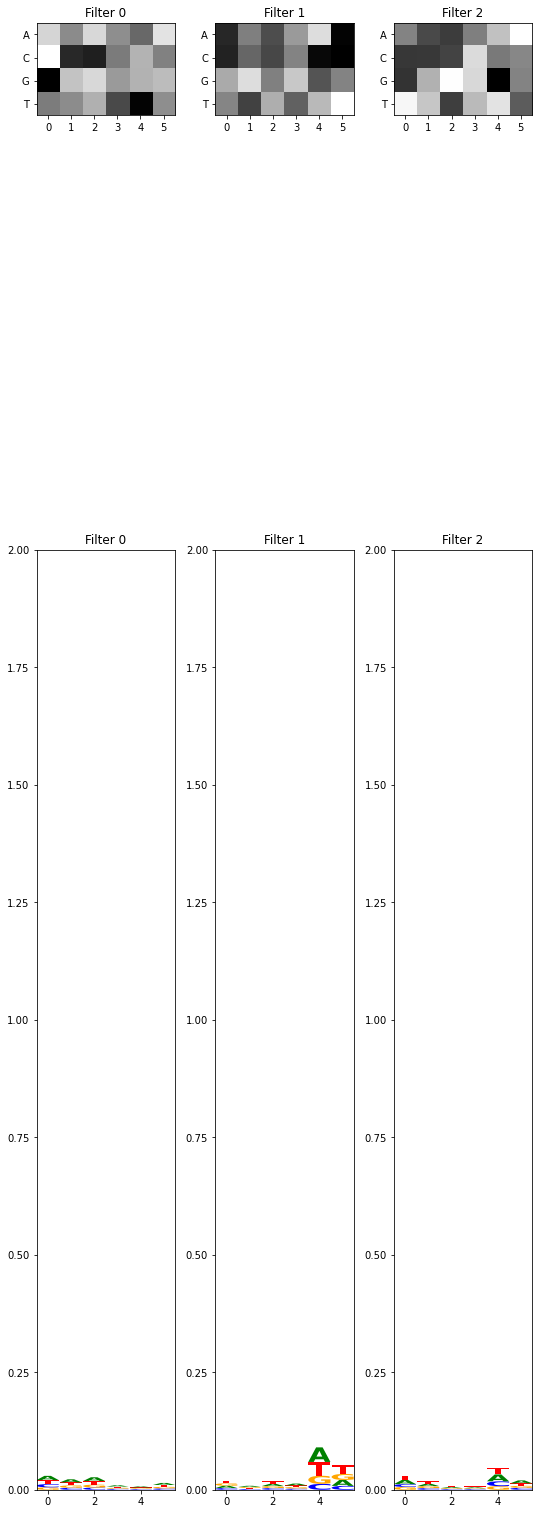

In [120]:
view_filters_and_logos(model_weights,filter_activations)

## Old tinkering

In [46]:
w = torch.tensor([10.0,100.0,1.0])
cel = nn.CrossEntropyLoss()
celw = nn.CrossEntropyLoss(weight=w)

In [48]:
a = torch.tensor([[1.0,2.0,3.0],
                  [1.0,3.0,2.0],
                  [3.0,1.0,2.0]])

b = torch.tensor([2,1,2])
c = torch.tensor([0,1,2])

print('normal')
print(cel(a,b))
print(cel(a,c))
print()
print('weighted')
print(celw(a,b))
print(celw(a,c))

normal
tensor(0.7409)
tensor(1.4076)

weighted
tensor(0.4174)
tensor(0.5968)


In [45]:
print(a.shape)
print(b.shape)

torch.Size([2, 3])
torch.Size([2])


In [104]:
seqs = train_df['locus_tag'].values #val_df['locus_tag'].values

p = quick_classify(mer8motif_model_cnn,seqs,oracle_syn)

EQU24_RS06320: pred:2 actual:0
EQU24_RS06320: pred:2 actual:0 ([6.231020450592041, -6.871827602386475, 6.793558597564697])
EQU24_RS06855: pred:1 actual:0
EQU24_RS06855: pred:1 actual:0 ([5.818170547485352, 6.306614875793457, -5.028451919555664])
EQU24_RS16240: pred:1 actual:0
EQU24_RS16240: pred:1 actual:0 ([6.875643253326416, 7.228374004364014, -6.141620635986328])


In [93]:
p.tolist()[0]

[6.06266975402832, 2.4189703464508057, -2.8052988052368164]

In [67]:
genes = train_df['locus_tag'].values
seqs = [torch.tensor(u.one_hot_encode(loc2seq[x])).unsqueeze(0).to(DEVICE).float() for x in genes]

preds = mer8motif_model_cnn(torch.stack(seqs).squeeze(1))

In [85]:
preds

tensor([[9.9989e-01, 1.0368e-04, 8.5303e-06],
        [9.9997e-01, 2.7287e-05, 2.8173e-06],
        [9.8730e-01, 5.0449e-05, 1.2647e-02],
        ...,
        [9.9740e-01, 1.9590e-05, 2.5840e-03],
        [9.9967e-01, 2.5071e-04, 8.1230e-05],
        [9.9950e-01, 4.3107e-04, 6.7942e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [85]:
val_df.value_counts('reg')

reg
0    334
2     11
1      8
dtype: int64

In [110]:
genes_with_motifs = ['EQU24_RS00275','EQU24_RS01000','EQU24_RS01145','EQU24_RS01350','EQU24_RS01510','EQU24_RS01840','EQU24_RS01895','EQU24_RS01900','EQU24_RS02065','EQU24_RS02090','EQU24_RS02305','EQU24_RS02735','EQU24_RS02990','EQU24_RS03550','EQU24_RS03555','EQU24_RS03610','EQU24_RS04575','EQU24_RS04690','EQU24_RS05030','EQU24_RS05090','EQU24_RS05095','EQU24_RS05810','EQU24_RS05885','EQU24_RS06285','EQU24_RS06410','EQU24_RS06960','EQU24_RS07465','EQU24_RS07825','EQU24_RS08030','EQU24_RS08830','EQU24_RS08840','EQU24_RS08860','EQU24_RS08880','EQU24_RS09300','EQU24_RS09730','EQU24_RS09760','EQU24_RS09900','EQU24_RS10145','EQU24_RS10685','EQU24_RS10700','EQU24_RS10745','EQU24_RS12075','EQU24_RS12370','EQU24_RS12810','EQU24_RS13170','EQU24_RS13370','EQU24_RS13465','EQU24_RS14795','EQU24_RS14835','EQU24_RS15280','EQU24_RS15800','EQU24_RS15850','EQU24_RS16395','EQU24_RS16400','EQU24_RS16545','EQU24_RS16935','EQU24_RS17340','EQU24_RS17960','EQU24_RS18175','EQU24_RS18350','EQU24_RS18600','EQU24_RS18860','EQU24_RS19095','EQU24_RS19160','EQU24_RS19290','EQU24_RS19580','EQU24_RS20100','EQU24_RS20210','EQU24_RS20225','EQU24_RS20485','EQU24_RS20940','EQU24_RS21145','EQU24_RS21675','EQU24_RS21805','EQU24_RS21815']
seqs_with_motifs = [loc2seq[x] for x in genes_with_motifs]
seqs_with_motifs = [torch.tensor(u.one_hot_encode(seq)).unsqueeze(0).to(DEVICE).float() for seq in seqs_with_motifs]
preds = mer8motif_model_cnn(torch.stack(seqs_with_motifs).squeeze(1))

In [113]:
quick_classify(mer8motif_model_cnn,genes_with_motifs,oracle_syn)

done
